In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

import nltk

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Input, Dense, Activation, Embedding, GlobalMaxPool1D, Flatten, MaxPooling1D 
from tensorflow.keras.layers import Conv1D, BatchNormalization, SpatialDropout1D, Bidirectional, LSTM, Dropout, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder

import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords

import sys
import datetime
import time

print("Python version: ", sys.version)
print("Version info.: ", sys.version_info)
print("TensorFlow version: ", tf.__version__)
print("TensorFlow.Keras version : ", tf.keras.__version__)

Python version:  3.6.10 |Anaconda, Inc.| (default, Mar 23 2020, 23:13:11) 
[GCC 7.3.0]
Version info.:  sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
TensorFlow version:  2.1.0
TensorFlow.Keras version :  2.2.4-tf


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
config.gpu_options.visible_device_list='0,1,2,3'

sess = tf.compat.v1.Session(config=config)
tf.debugging.set_log_device_placement(True)
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}\n'.format(strategy.num_replicas_in_sync))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 6.0
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:05:00.0, compute capability: 6.0
/job:localhost/replica:0/task:0/device:GPU:2 -> device: 2, name: Tesla P100-PCIE-16GB, pci bus id: 0000:84:00.0, compute capability: 6.0
/job:localhost/replica:0/task:0/device:GPU:3 -> device: 3, name: Tesla P100-PCIE-16GB, pci bus id: 0000:85:00.0, compute capability: 6.0
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:2 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:3 -> device: XLA_GPU device

INFO:tensorflow:Using MirroredStrategy with devices ('/job:l

In [3]:
path = '/data/user/mahoque/data_science_project/data/'
embedding_file=f'{path}glove.6B.50d.txt'
train_data_file = f'{path}emotion/train.csv'
test_data_file = f'{path}emotion/test.csv'
test_data_label_file=f'{path}test_labels.csv'

emotion_data_file=f'{path}emotion/text_emotion.csv'

corona_data_file=f'{path}emotion/df_corona.csv'
administration_data_file=f'{path}emotion/df_trump.csv'

tweet_data_file = f'{path}tweet_data.csv'

In [4]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [5]:
import preprocessor as p

stop_words = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL'])

train = pd.read_csv(train_data_file)
test = pd.read_csv(test_data_file)
test_label = pd.read_csv(test_data_label_file)

tweet_data = pd.read_csv(tweet_data_file)
tweet_data = pd.DataFrame(tweet_data)

administration_data = pd.read_csv(administration_data_file)
display(administration_data.shape)
administration_data = administration_data[:500000]
administration_data = administration_data["tweet"].values
display(administration_data.shape)

display(tweet_data.shape)
display(train.shape)
display(test.shape)
#print(tweet_data.sample(2))
display(tweet_data.head(5))
display(train.head(5))
#print(p.clean(train["text"][2]))

list_sentences_train = train["text"].fillna("_na_").values
#list_classes = ["neutral", "sadness", "enthusiasm", "empty", "worry", "love", "fun"]
list_classes = ["negative", "neutral", "positive"]

y_tr = train["sentiment"]
y_tr = np.array(y_tr)
label_encoder = LabelEncoder()
y_tr = label_encoder.fit_transform(y_tr)
y = to_categorical(y_tr)
print(y[0])

test_labels = test["sentiment"]
test_labels = np.array(test_labels)
test_labels = label_encoder.fit_transform(test_labels)
test_labels = to_categorical(test_labels)
print(test_labels[0])
#print(sum())
display(test.head(5))
list_sentences_test = test["text"].fillna("_na_").values


crawled_tweet = tweet_data["tweet"]
crawled_tweet = crawled_tweet[:100000]



(1340214, 4)

(500000,)

(650000, 4)

(27481, 4)

(3534, 3)

,Unnamed: 0,created_at,id,tweet
0,0,Thu Mar 12 21:12:58 +0000 2020,1238211405850923008,RT @Notorious4zzzz: Ain’t never gone stop fw C...
1,1,Thu Mar 12 21:12:58 +0000 2020,1238211405725270021,RT @KevinOConnorNBA: “The problem is that we a...
2,2,Thu Mar 12 21:12:58 +0000 2020,1238211405574070272,RT @sweatyhairy: dam yall really picked the wo...
3,3,Thu Mar 12 21:12:58 +0000 2020,1238211405297389571,RT @JheneAiko: #CHILOMBO deluxe coming soon 👀🌋...
4,4,Thu Mar 12 21:12:58 +0000 2020,1238211405284872193,RT @thepanda317: Mfs doing too much for likes ...


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


[0. 1. 0.]
[0. 1. 0.]


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [6]:
def processTweets(list_of_tweets):
    processedTweets=[]
    for tweet in list_of_tweets:
        processedTweets.append((clean_text(tweet)))
    return processedTweets

In [7]:
import string
from nltk.stem.snowball import SnowballStemmer 

def clean_text(text):
    
    text = str(text)
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    
    ## Clean the text
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text) # remove URLs
    text = re.sub('@[^\s]+', 'AT', text) # remove usernames
    text = re.sub(r'#([^\s]+)', r'\1', text) # remove the # in #hashtag
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    
    ## Stemming
    #text = text.split()
    #stemmer = SnowballStemmer('english')
    #stemmed_words = [stemmer.stem(word) for word in text]
    #text = " ".join(stemmed_words)
    return text

In [8]:
list_sentences_train = processTweets(list_sentences_train)
list_sentences_test = processTweets(list_sentences_test)


In [9]:
crawled_tweets = processTweets(administration_data)

In [10]:
print(crawled_tweets[0])

thanks reply hope somehow actually reaches someone


In [11]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train_1 = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test_1 = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train_1, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test_1, maxlen=maxlen)

In [12]:
print(list_tokenized_train_1[0])
print(X_t[0])

[9729, 8]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 9729    8]


In [13]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))

In [14]:
print(len(embeddings_index))

400000


In [14]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/data/user/mahoque/.conda/envs/cs765/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(0.020940498, 0.6441043)

In [15]:
word_index = tokenizer.word_index
print(len(word_index))
nb_words = min(max_features, len(word_index))
print(nb_words)
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
count = 0
for word, i in word_index.items():
    if i >= max_features: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
    else:
        count = count+1
print(embedding_matrix.shape)
print(count)

23806
20000
(20000, 50)
4631


In [16]:
with strategy.scope():
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
    #x = LSTM(100)(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(3, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarIsInitializedOp in device /job:localhost

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          40400     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153   

In [20]:
history = model.fit(X_t, y, batch_size=128, epochs=8, validation_split=0.2);

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Prefet

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op __inference_distributed_function_30547 in device /job:localhost/replica:0/task:0/device:GPU:0
21984/21984 [==============================] - 170s 8ms/sample - loss: 0.5458 - accuracy: 0.7235 - val_loss: 0.4670 - val_accuracy: 0.7821
Epoch 2/8
21888/21984 [============================>.] - ETA: 0s - loss: 0.432

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


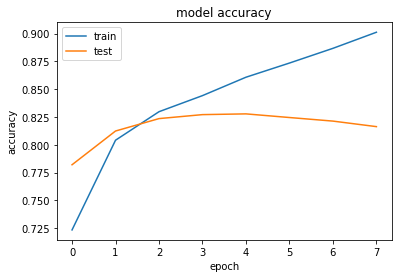

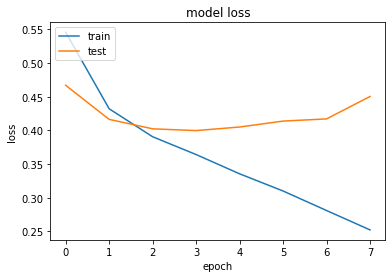

In [21]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
modelPath = '/data/user/mahoque/data_science_project/model/best_model_'+datetime.datetime.now().strftime("%m-%d-%Y-%I-%M")+'.h5'
weightPath = '/data/user/mahoque/data_science_project/model/best_model_weight'+datetime.datetime.now().strftime("%m-%d-%Y-%I-%M")+'.hdf5'
model.save(modelPath)
model.save_weights(weightPath)

In [23]:
print("modelPath: ", modelPath)
print("weightPath: ", weightPath)

modelPath:  /data/user/mahoque/data_science_project/model/best_model_04-26-2020-04-35.h5
weightPath:  /data/user/mahoque/data_science_project/model/best_model_weight04-26-2020-04-35.hdf5


In [17]:
#model.load_weights(weightPath)
model.load_weights('/data/user/mahoque/data_science_project/model/best_model_weight04-26-2020-04-35.hdf5')

In [18]:
print("Total number of test examples: ", X_te.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (3534, 100)
Total number of labels: (3534, 3)


In [19]:
batch_size = 128
test_loss, test_score = model.evaluate(X_te, test_labels, batch_size=batch_size)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

In [20]:
# Get predictions
preds = model.predict(X_te, batch_size=batch_size)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

<Figure size 432x288 with 0 Axes>

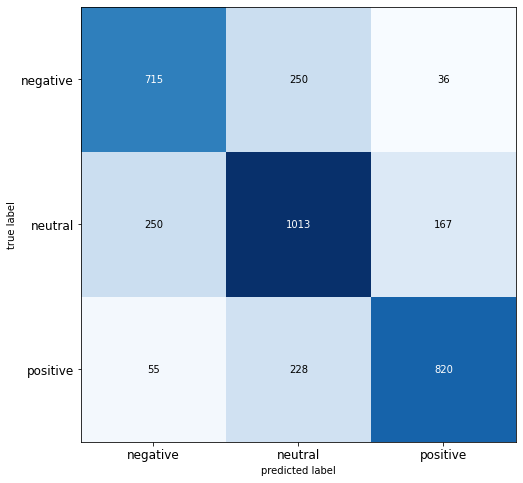

In [21]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), list_classes, fontsize=12)
plt.yticks(range(3), list_classes, fontsize=12)
#plt.savefigure
plt.show()

In [22]:
seq_crawled_tweet = tokenizer.texts_to_sequences(crawled_tweets)

seq_crawled_tweet = pad_sequences(seq_crawled_tweet, maxlen=maxlen)

In [23]:

positive_tweets = []
negative_tweets = []
neutral_tweets = []
positive_counter = 0
negative_counter = 0
neutral_counter = 0

# Get predictions
predictions = model.predict(seq_crawled_tweet, batch_size=batch_size)
print('predictions done')
for n, prediction in enumerate(predictions):
    pred = predictions.argmax(axis=-1)[n]
    #print(crawled_tweet[n],"\nPrediction:",list_classes[pred],"\n")
    if list_classes[pred] == "positive":
        positive_counter = positive_counter+1
        positive_tweets.append(crawled_tweets[n])
    elif list_classes[pred] == "negative":
        negative_counter = negative_counter+1
        negative_tweets.append(crawled_tweets[n])
    elif list_classes[pred] == "neutral":
        neutral_counter = neutral_counter+1
        neutral_tweets.append(crawled_tweets[n])

print(positive_counter)
print(negative_counter)
print(neutral_counter)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

KeyboardInterrupt: 

In [24]:
print(len(predictions))
tmp = predictions[:200000]
print(len(tmp))

500000
200000


In [25]:
positive_tweets = []
negative_tweets = []
neutral_tweets = []
positive_counter = 0
negative_counter = 0
neutral_counter = 0

for n, prediction in enumerate(tmp):
    if n%1000 == 0:
        print(n)
    pred = tmp.argmax(axis=-1)[n]
    #print(crawled_tweet[n],"\nPrediction:",list_classes[pred],"\n")
    if list_classes[pred] == "positive":
        positive_counter = positive_counter+1
        positive_tweets.append(crawled_tweets[n])
    elif list_classes[pred] == "negative":
        negative_counter = negative_counter+1
        negative_tweets.append(crawled_tweets[n])
    elif list_classes[pred] == "neutral":
        neutral_counter = neutral_counter+1
        neutral_tweets.append(crawled_tweets[n])

print(positive_counter)
print(negative_counter)
print(neutral_counter)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

[('trump', 7442), ('president', 4462), ('like', 2230), ('people', 1820), ('donald', 1670), ('would', 1552), ('great', 1509), ('hace', 1339), ('good', 1318), ('american', 1239)]
[('trump', 53774), ('donald', 13298), ('president', 12109), ('seriously', 7416), ('coronavirus', 7376), ('campaign', 6990), ('people', 6350), ('pandemic', 6176), ('part', 6110), ('issued', 6013)]


<BarContainer object of 10 artists>

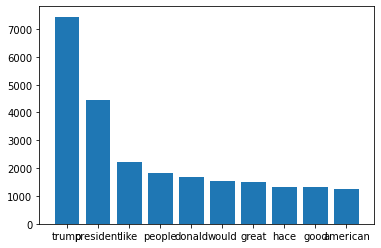

In [32]:
pos = get_top_n_words(positive_tweets, 10)
neg = get_top_n_words(negative_tweets, 10)
print(pos)
print(neg)

dic_pos = dict(pos) 
keys = dic_pos.keys()
values = dic_pos.values()
plt.bar(keys, values)

<BarContainer object of 10 artists>

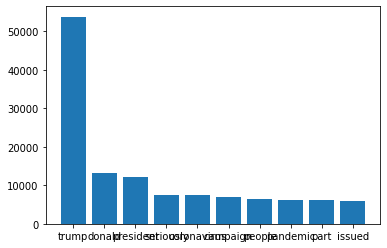

In [28]:
dic_neg = dict(neg) 
keys = dic_neg.keys()
values = dic_neg.values()
plt.bar(keys, values)

In [29]:
def to_percents(data):
    total = float(sum(v for _, v in data))
    data[:] = [(k, v / total) for k, v in data]
    return data

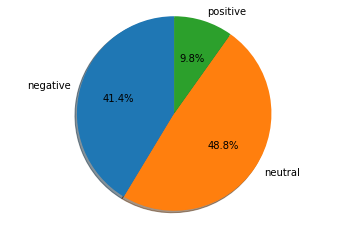

In [30]:
labels = list_classes
sizes = [negative_counter, neutral_counter, positive_counter]
explode = (0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()